In [1]:
!cp -r "/kaggle/input/lane-segmentation/data" /kaggle/working/

In [ ]:
#!pip install -q segmentation-models-pytorch albumentations
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
from glob import glob

# Cấu hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4  # class id: 0, 1, 2, 3 (1, 2, 3, 4)
image_size = (384, 512)

# Định nghĩa Dataset
class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]))  # uint8, shape: HxW
        mask = mask - 1  # Ánh xạ từ [1, 4] về [0, 3]

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        return img, mask.long()

# Load dữ liệu
base_dir = '/kaggle/working/data'
train_imgs = sorted(glob(os.path.join(base_dir, 'train/images/*.jpg')))
train_masks = sorted(glob(os.path.join(base_dir, 'train/masks/*.png')))
val_imgs = sorted(glob(os.path.join(base_dir, 'val/images/*.jpg')))
val_masks = sorted(glob(os.path.join(base_dir, 'val/masks/*.png')))
test_imgs = sorted(glob(os.path.join(base_dir, 'test/images/*.jpg')))
test_masks = sorted(glob(os.path.join(base_dir, 'test/masks/*.png')))

# Transform
train_tf = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15, rotate_limit=15, border_mode=0, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, border_mode=0, p=0.2),
    A.GridDistortion(num_steps=5, distort_limit=0.3, border_mode=0, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
    A.RandomGamma(p=0.3),
    A.CLAHE(p=0.2),
    A.MotionBlur(blur_limit=5, p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1),
    A.GaussNoise(var_limit=(10, 60), p=0.3),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, mask_fill_value=0, p=0.1),
    A.Resize(384, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(384, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# DataLoader
batch_size = 8
train_dataset = SegDataset(train_imgs, train_masks, transform=train_tf)
val_dataset = SegDataset(val_imgs, val_masks, transform=val_tf)
test_dataset = SegDataset(test_imgs, test_masks, transform=val_tf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_35/408110830.py:58: UserWarning: Argument(s) 'alpha_affine, border_mode' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=20, border_mode=0, p=0.2),
/tmp/ipykernel_35/408110830.py:59: UserWarning: Argument(s) 'border_mode' are not valid for transform GridDistortion
  A.GridDistortion(num_steps=5, distort_limit=0.3, border_mode=0, p=0.2),
/tmp/ipykernel_35/408110830.py:67: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 60), p=0.3),
/tmp/ipykernel_35/408110830.py:68: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_

In [ ]:
# Khởi tạo loss function 
loss_fn = torch.nn.CrossEntropyLoss()

# Khởi tạo model, optimizer, scheduler
model = smp.DeepLabV3Plus(
    encoder_name='mobilenet_v2',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes,
    encoder_depth=5,
    decoder_dropout=0.2
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

# Các hàm metric và training
def iou_score(output, target, n_classes=4):
    smooth = 1e-6
    output = torch.argmax(output, dim=1)
    ious = []
    for cls in range(n_classes):
        pred_inds = (output == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append((intersection + smooth) / (union + smooth))
    ious = [iou for iou in ious if not np.isnan(iou)]
    return np.mean(ious) if ious else 0

def calculate_metrics(output, target, n_classes=4):
    smooth = 1e-6
    output = torch.argmax(output, dim=1)
    ious = []
    dices = []
    correct = (output == target).sum().item()
    total = torch.numel(output)
    pixel_acc = correct / total if total > 0 else 0
    precisions = []
    recalls = []
    for cls in range(n_classes):
        pred_inds = (output == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append((intersection + smooth) / (union + smooth))
        intersection_dice = (pred_inds & target_inds).sum().item()
        dice = (2 * intersection_dice + smooth) / (pred_inds.sum().item() + target_inds.sum().item() + smooth)
        if pred_inds.sum().item() + target_inds.sum().item() == 0:
            dices.append(np.nan)
        else:
            dices.append(dice)
        true_positives = intersection
        pred_positives = pred_inds.sum().item()
        true_positives_recall = target_inds.sum().item()
        precision = true_positives / (pred_positives + smooth) if pred_positives > 0 else np.nan
        recall = true_positives / (true_positives_recall + smooth) if true_positives_recall > 0 else np.nan
        precisions.append(precision)
        recalls.append(recall)
    mean_iou = np.mean([iou for iou in ious if not np.isnan(iou)]) if ious else 0
    mean_dice = np.mean([dice for dice in dices if not np.isnan(dice)]) if dices else 0
    mean_precision = np.mean([p for p in precisions if not np.isnan(p)]) if precisions else 0
    mean_recall = np.mean([r for r in recalls if not np.isnan(r)]) if recalls else 0
    return {
        'mean_iou': mean_iou,
        'mean_dice': mean_dice,
        'pixel_acc': pixel_acc,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall
    }

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    total_metrics = {'mean_iou': 0, 'mean_dice': 0, 'pixel_acc': 0, 'mean_precision': 0, 'mean_recall': 0}
    for imgs, masks in tqdm(loader):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        metrics = calculate_metrics(preds, masks, n_classes=num_classes)
        for key in total_metrics:
            total_metrics[key] += metrics[key]
    n = len(loader)
    return total_loss / n, {key: value / n for key, value in total_metrics.items()}

def validate(model, loader):
    model.eval()
    total_loss = 0
    total_metrics = {'mean_iou': 0, 'mean_dice': 0, 'pixel_acc': 0, 'mean_precision': 0, 'mean_recall': 0}
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            total_loss += loss.item()
            metrics = calculate_metrics(preds, masks, n_classes=num_classes)
            for key in total_metrics:
                total_metrics[key] += metrics[key]
    n = len(loader)
    return total_loss / n, {key: value / n for key, value in total_metrics.items()}

def test(model, loader, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    total_loss = 0
    total_metrics = {'mean_iou': 0, 'mean_dice': 0, 'pixel_acc': 0, 'mean_precision': 0, 'mean_recall': 0}
    with torch.no_grad():
        for imgs, masks in tqdm(loader):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            total_loss += loss.item()
            metrics = calculate_metrics(preds, masks, n_classes=num_classes)
            for key in total_metrics:
                total_metrics[key] += metrics[key]
    n = len(loader)
    return total_loss / n, {key: value / n for key, value in total_metrics.items()}


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# training
best_loss = float('inf')
patience = 5
trigger_times = 0
epochs = 20
save_path = '/kaggle/working/deeplabv3plus_best.pth'

train_losses, val_losses = [], []
train_metrics = {'mean_iou': [], 'mean_dice': [], 'pixel_acc': [], 'mean_precision': [], 'mean_recall': []}
val_metrics = {'mean_iou': [], 'mean_dice': [], 'pixel_acc': [], 'mean_precision': [], 'mean_recall': []}

log_file = open('/kaggle/working/train_log.txt', 'w')

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_loss, train_metric_values = train_one_epoch(model, train_loader)
    val_loss, val_metric_values = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    for key in train_metrics:
        train_metrics[key].append(train_metric_values[key])
        val_metrics[key].append(val_metric_values[key])

    scheduler.step(val_loss)

    epoch_time = time.time() - start_time
    log_line = (f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                f"Train IoU={train_metric_values['mean_iou']:.4f}, Val IoU={val_metric_values['mean_iou']:.4f}, "
                f"Train Dice={train_metric_values['mean_dice']:.4f}, Val Dice={val_metric_values['mean_dice']:.4f}, "
                f"Train Pixel Acc={train_metric_values['pixel_acc']:.4f}, Val Pixel Acc={val_metric_values['pixel_acc']:.4f}, "
                f"Train Precision={train_metric_values['mean_precision']:.4f}, Val Precision={val_metric_values['mean_precision']:.4f}, "
                f"Train Recall={train_metric_values['mean_recall']:.4f}, Val Recall={val_metric_values['mean_recall']:.4f}, "
                f"Time={epoch_time:.1f}s\n")
    print(log_line.strip())
    log_file.write(log_line)
    log_file.flush()

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved best model")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break


100%|██████████| 2254/2254 [09:43<00:00,  3.86it/s]


Epoch 1: Train Loss=0.4687, Val Loss=0.2577, Train IoU=0.6402, Val IoU=0.4788, Train Dice=0.7593, Val Dice=0.5476, Train Pixel Acc=0.8283, Val Pixel Acc=0.9101, Train Precision=0.7749, Val Precision=0.6049, Train Recall=0.7719, Val Recall=0.6045, Time=626.2s
Saved best model


100%|██████████| 2254/2254 [09:52<00:00,  3.81it/s]


Epoch 2: Train Loss=0.3410, Val Loss=0.2279, Train IoU=0.7197, Val IoU=0.5256, Train Dice=0.8221, Val Dice=0.5985, Train Pixel Acc=0.8774, Val Pixel Acc=0.9240, Train Precision=0.8336, Val Precision=0.6346, Train Recall=0.8294, Val Recall=0.6548, Time=635.0s
Saved best model


100%|██████████| 2254/2254 [09:51<00:00,  3.81it/s]


Epoch 3: Train Loss=0.3027, Val Loss=0.1963, Train IoU=0.7447, Val IoU=0.5663, Train Dice=0.8399, Val Dice=0.6416, Train Pixel Acc=0.8917, Val Pixel Acc=0.9306, Train Precision=0.8508, Val Precision=0.6789, Train Recall=0.8455, Val Recall=0.6934, Time=635.2s
Saved best model


100%|██████████| 2254/2254 [09:51<00:00,  3.81it/s]


Epoch 4: Train Loss=0.2751, Val Loss=0.1793, Train IoU=0.7651, Val IoU=0.5808, Train Dice=0.8551, Val Dice=0.6556, Train Pixel Acc=0.9010, Val Pixel Acc=0.9370, Train Precision=0.8646, Val Precision=0.6879, Train Recall=0.8604, Val Recall=0.7215, Time=634.5s
Saved best model


100%|██████████| 2254/2254 [09:50<00:00,  3.82it/s]


Epoch 5: Train Loss=0.2638, Val Loss=0.1761, Train IoU=0.7727, Val IoU=0.5762, Train Dice=0.8602, Val Dice=0.6509, Train Pixel Acc=0.9053, Val Pixel Acc=0.9372, Train Precision=0.8685, Val Precision=0.7113, Train Recall=0.8650, Val Recall=0.7017, Time=633.8s
Saved best model


100%|██████████| 2254/2254 [09:51<00:00,  3.81it/s]


Epoch 6: Train Loss=0.2478, Val Loss=0.1732, Train IoU=0.7848, Val IoU=0.6029, Train Dice=0.8690, Val Dice=0.6810, Train Pixel Acc=0.9110, Val Pixel Acc=0.9384, Train Precision=0.8774, Val Precision=0.6964, Train Recall=0.8727, Val Recall=0.7514, Time=635.1s
Saved best model


100%|██████████| 2254/2254 [09:51<00:00,  3.81it/s]


Epoch 7: Train Loss=0.2404, Val Loss=0.1659, Train IoU=0.7905, Val IoU=0.6068, Train Dice=0.8728, Val Dice=0.6823, Train Pixel Acc=0.9135, Val Pixel Acc=0.9403, Train Precision=0.8818, Val Precision=0.7180, Train Recall=0.8763, Val Recall=0.7325, Time=634.6s
Saved best model


100%|██████████| 2254/2254 [09:51<00:00,  3.81it/s]


Epoch 8: Train Loss=0.2295, Val Loss=0.1568, Train IoU=0.7994, Val IoU=0.6079, Train Dice=0.8791, Val Dice=0.6794, Train Pixel Acc=0.9173, Val Pixel Acc=0.9436, Train Precision=0.8866, Val Precision=0.7134, Train Recall=0.8817, Val Recall=0.7395, Time=634.2s
Saved best model


100%|██████████| 2254/2254 [09:49<00:00,  3.82it/s]


Epoch 9: Train Loss=0.2306, Val Loss=0.1569, Train IoU=0.8000, Val IoU=0.6142, Train Dice=0.8796, Val Dice=0.6877, Train Pixel Acc=0.9175, Val Pixel Acc=0.9438, Train Precision=0.8884, Val Precision=0.7112, Train Recall=0.8817, Val Recall=0.7517, Time=632.6s


100%|██████████| 2254/2254 [09:49<00:00,  3.82it/s]


Epoch 10: Train Loss=0.2214, Val Loss=0.1601, Train IoU=0.8056, Val IoU=0.6143, Train Dice=0.8833, Val Dice=0.6885, Train Pixel Acc=0.9206, Val Pixel Acc=0.9423, Train Precision=0.8917, Val Precision=0.7079, Train Recall=0.8853, Val Recall=0.7571, Time=632.5s


100%|██████████| 2254/2254 [09:49<00:00,  3.82it/s]


Epoch 11: Train Loss=0.2181, Val Loss=0.1525, Train IoU=0.8071, Val IoU=0.6175, Train Dice=0.8839, Val Dice=0.6903, Train Pixel Acc=0.9213, Val Pixel Acc=0.9458, Train Precision=0.8924, Val Precision=0.7215, Train Recall=0.8863, Val Recall=0.7500, Time=634.1s
Saved best model


100%|██████████| 2254/2254 [09:52<00:00,  3.80it/s]


Epoch 12: Train Loss=0.2120, Val Loss=0.1454, Train IoU=0.8135, Val IoU=0.6259, Train Dice=0.8887, Val Dice=0.6976, Train Pixel Acc=0.9237, Val Pixel Acc=0.9480, Train Precision=0.8965, Val Precision=0.7316, Train Recall=0.8906, Val Recall=0.7554, Time=635.2s
Saved best model


100%|██████████| 2254/2254 [09:49<00:00,  3.83it/s]


Epoch 13: Train Loss=0.2109, Val Loss=0.1502, Train IoU=0.8156, Val IoU=0.6211, Train Dice=0.8900, Val Dice=0.6927, Train Pixel Acc=0.9245, Val Pixel Acc=0.9467, Train Precision=0.8975, Val Precision=0.7311, Train Recall=0.8922, Val Recall=0.7488, Time=632.2s


 53%|█████▎    | 1191/2254 [05:11<04:38,  3.82it/s]


KeyboardInterrupt: 

⏱ Thời gian suy luận: 8.31 ms


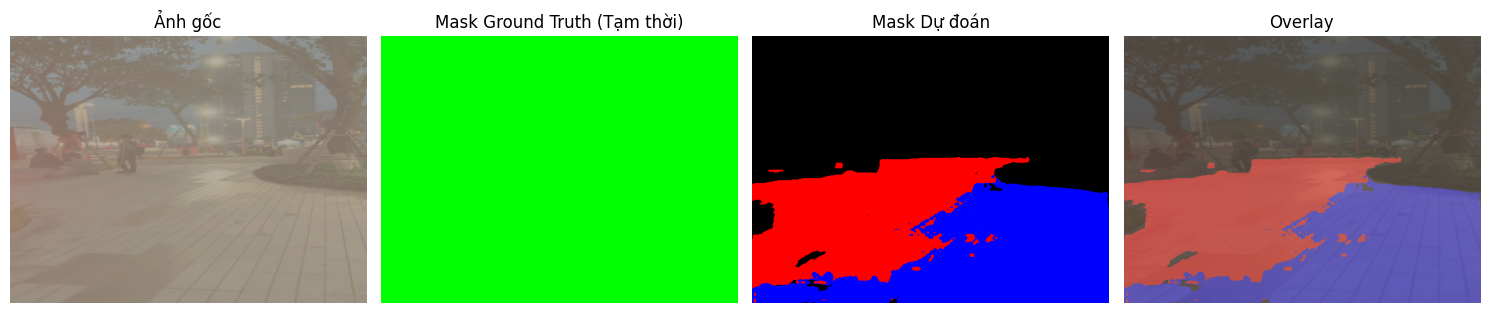

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [ ]:
import torch
import segmentation_models_pytorch as smp
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Hàm load model
def load_model(weights_path, num_classes=4):
    model = smp.DeepLabV3Plus(
        encoder_name='mobilenet_v2',
        encoder_weights=None,  
        in_channels=3,
        classes=num_classes,
    )
    model.load_state_dict(torch.load(weights_path, map_location='cuda'))
    model.eval().to('cuda')
    return model

# Hàm đo thời gian suy luận
@torch.no_grad()
def infer_and_measure(model, image_tensor):
    start = time.time()
    output = model(image_tensor)
    end = time.time()
    infer_time_ms = (end - start) * 1000  # milliseconds
    return output, infer_time_ms

# Màu overlay cho từng lớp
COLORS = [
    (0, 255, 0),       # lớp 0
    (255, 0, 0),       # lớp 1
    (0, 0, 255),       # lớp 2
    (0, 0, 0),         # lớp 3 - nền
]

# Hàm decode mask thành màu
def decode_segmap(mask, num_classes):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls in range(num_classes):
        color_mask[mask == cls] = COLORS[cls]
    return color_mask

# Hàm phân tích vị trí
def analyze_position(pred):
    h, w = pred.shape
    bottom = pred[-h // 4:, :]  # 1/4 dưới ảnh
    total_pixels = bottom.size

    # Đếm số lượng pixel của từng lớp trong vùng đáy
    unique, counts = np.unique(bottom, return_counts=True)
    class_counts = dict(zip(unique, counts))

    # Ngưỡng 20%
    threshold = 0.2 * total_pixels

    # Kiểm tra nếu vùng đáy có đủ phần trăm lớp 2 (vỉa hè) hoặc lớp 0 (vạch kẻ)
    if class_counts.get(2, 0) > threshold:
        return "Bạn đang đứng trên vỉa hè."
    elif class_counts.get(0, 0) > threshold:
        return "Bạn đang đứng trên vạch kẻ đường cho người đi bộ."

    # Nếu không an toàn → tìm hướng di chuyển
    guidance = "Đang ở khu vực không an toàn! "

    # Chia ảnh theo chiều dọc làm 2 phần
    left = pred[:, :w // 2]
    right = pred[:, w // 2:]

    def contains_enough(region, cls):
        region_total = region.size
        region_counts = dict(zip(*np.unique(region, return_counts=True)))
        return region_counts.get(cls, 0) > 0.2 * region_total
    def contains(region, cls):
        region_total = region.size
        region_counts = dict(zip(*np.unique(region, return_counts=True)))
        return region_counts.get(cls, 0) > 0.05 * region_total
    # Ưu tiên hướng phải
    if contains(right, 2):
        guidance += "Hãy đi về bên phải để lên vỉa hè."
    elif contains(right, 0):
        guidance += "Hãy đi về bên phải để tới vạch kẻ đường."
    elif contains(left, 2):
        guidance += "Hãy đi về bên trái để lên vỉa hè."
    elif contains(left, 0):
        guidance += "Hãy đi về bên trái để tới vạch kẻ đường."
    else:
        guidance += "Không tìm thấy vỉa hè hoặc vạch kẻ đường."

    return guidance

# Hàm dự đoán và hiển thị
def predict_image(img, device='cuda', num_classes=4):
    # Chuyển ảnh BGR (OpenCV) sang RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Áp dụng transform
    transform = A.Compose([
        A.Resize(384, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    aug = transform(image=img_rgb)
    input_tensor = aug['image'].unsqueeze(0).to(device)

    # Suy luận
    with torch.no_grad():
        output, infer_time_ms = infer_and_measure(model, input_tensor)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        print(f"⏱ Thời gian suy luận: {infer_time_ms:.2f} ms")

    # Unnormalize ảnh gốc
    image_np = img_rgb / 255.0  
    image_np = (image_np * np.array([0.229, 0.224, 0.225]) +
                np.array([0.485, 0.456, 0.406]))
    image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)

    # Tạo mask màu
    pred_color = decode_segmap(pred, num_classes)
    mask_color = decode_segmap(np.ones_like(pred) * 0, num_classes) 

    # Resize ảnh gốc để khớp với mask
    img_resized = cv2.resize(image_np, (512, 384))
    overlay = cv2.addWeighted(pred_color, 0.4, img_resized, 0.6, 0)

    # Hiển thị kết quả 
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img_resized)
    plt.title("Ảnh gốc")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask_color)
    plt.title("Mask Ground Truth (Tạm thời)")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_color)
    plt.title("Mask Dự đoán")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Phân tích logic đứng
    guidance = analyze_position(pred)
    return guidance


model_path = "/kaggle/working/deeplabv3plus_best.pth" 
model = load_model(model_path, num_classes=4)

test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0001.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 10.41 ms


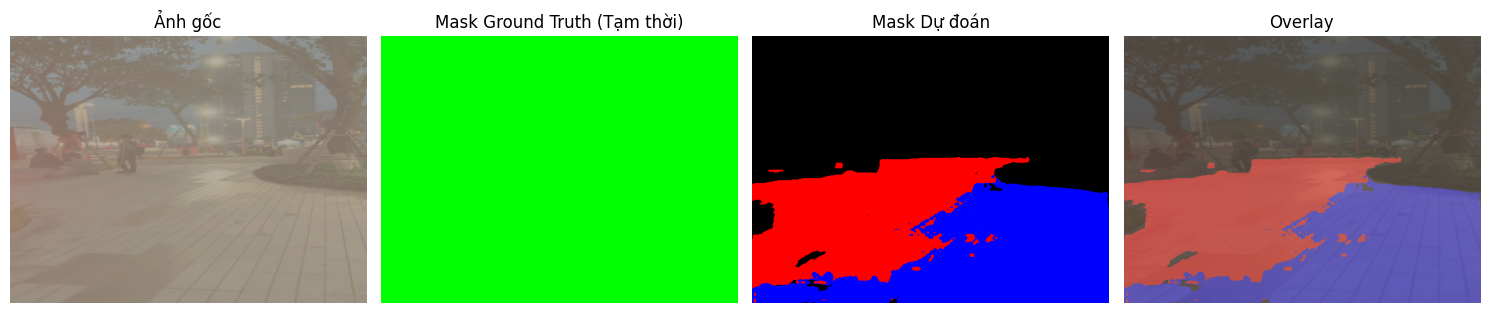

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [58]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0001.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 10.81 ms


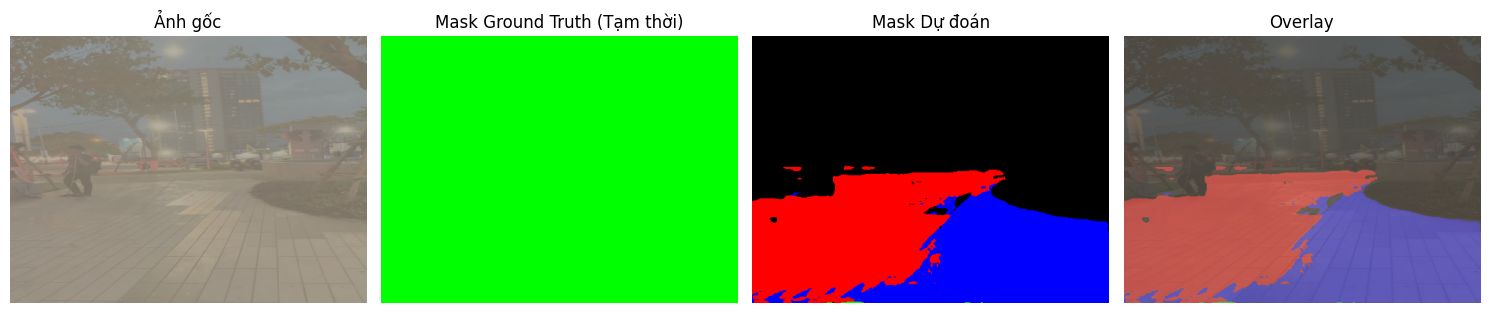

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [59]:

test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0002.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 10.58 ms


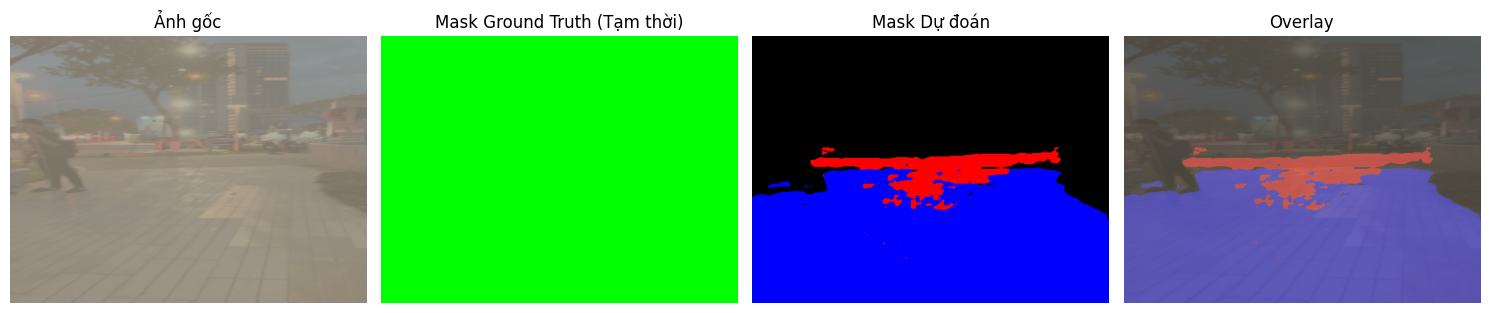

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [60]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0003.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 10.18 ms


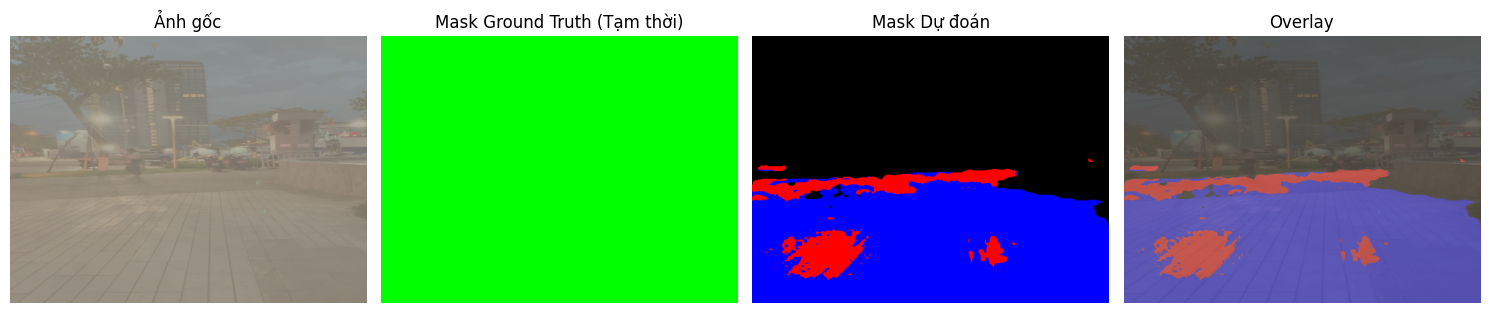

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [61]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0004.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 8.67 ms


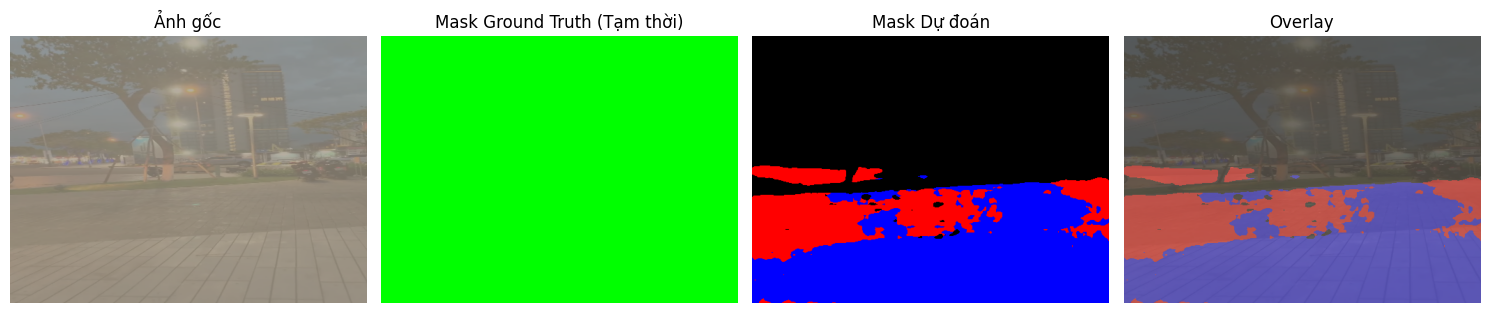

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [62]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0005.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 10.29 ms


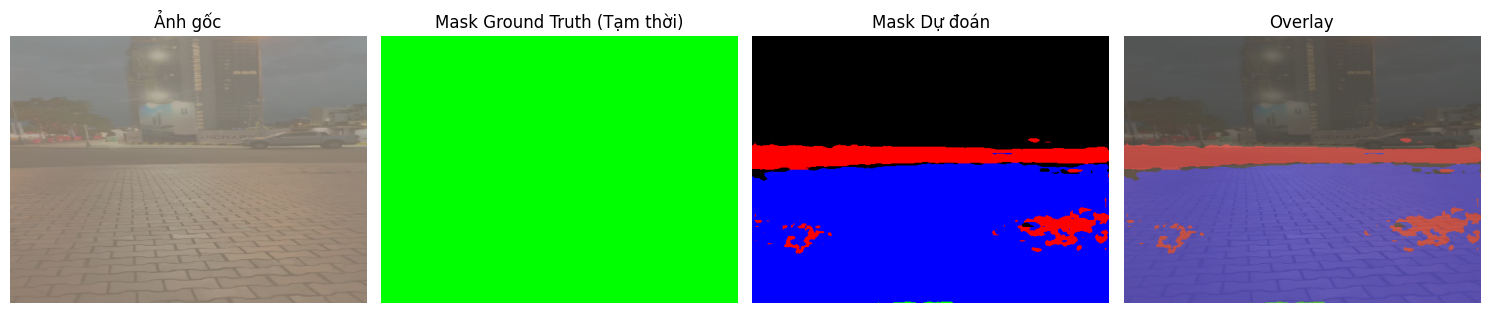

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [63]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0009.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.15 ms


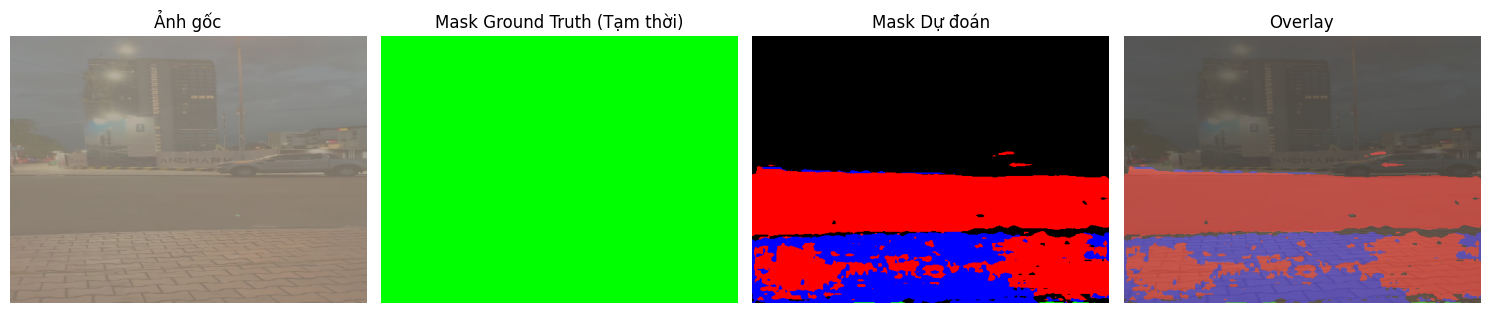

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [64]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0011.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.10 ms


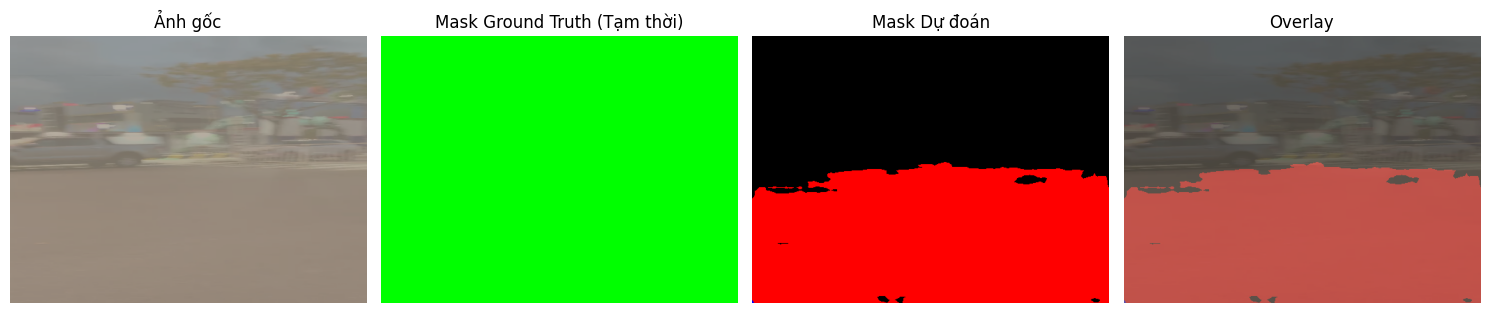

Hướng dẫn: Đang ở khu vực không an toàn! Không tìm thấy vỉa hè hoặc vạch kẻ đường.


In [65]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0014.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 8.67 ms


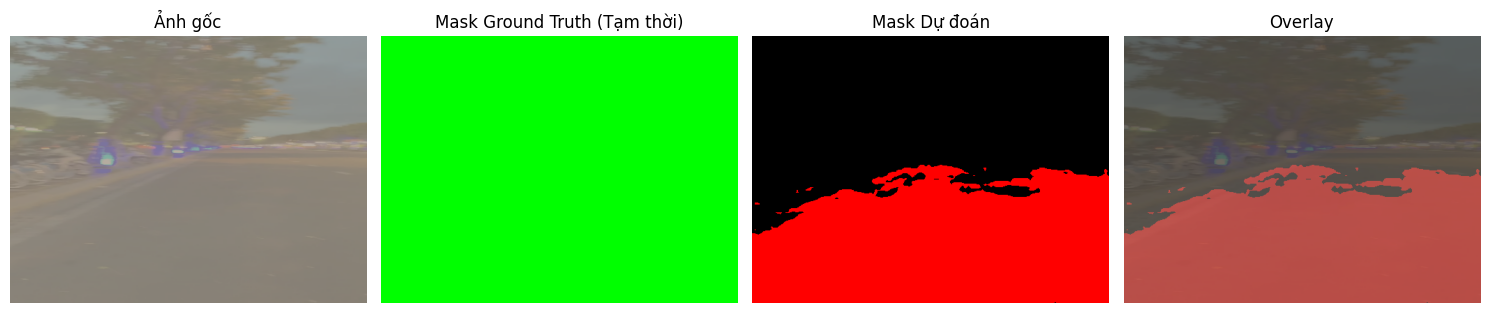

Hướng dẫn: Đang ở khu vực không an toàn! Không tìm thấy vỉa hè hoặc vạch kẻ đường.


In [66]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0022.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 11.30 ms


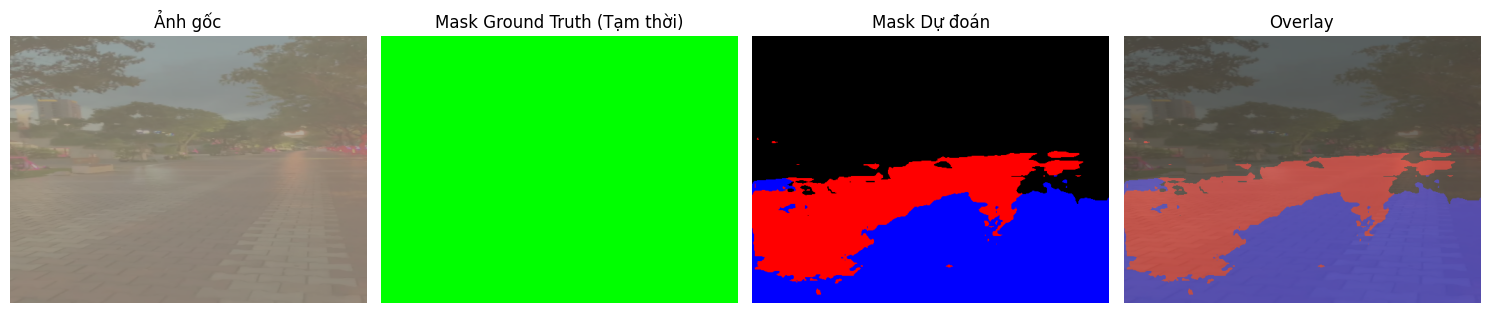

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [67]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0026.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.63 ms


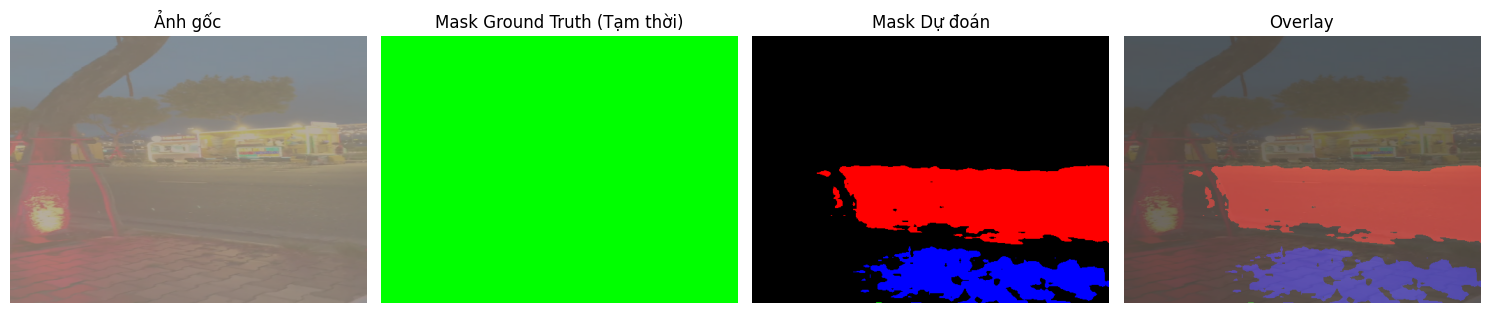

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [68]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0028.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.61 ms


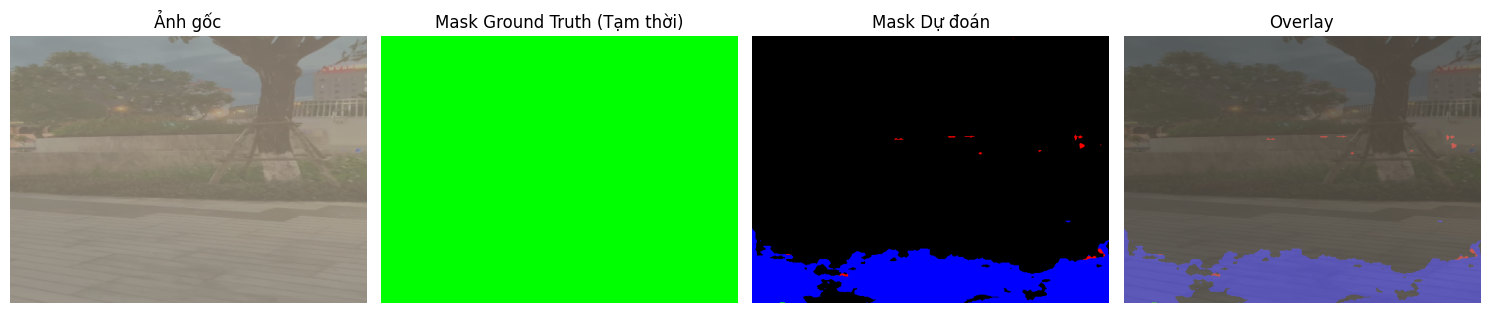

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [69]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0033.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.76 ms


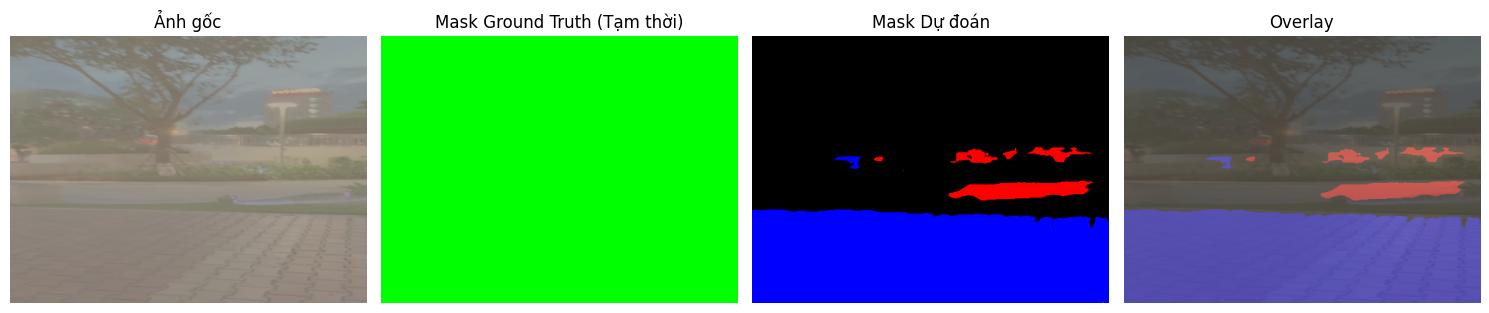

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [70]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0031.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 10.41 ms


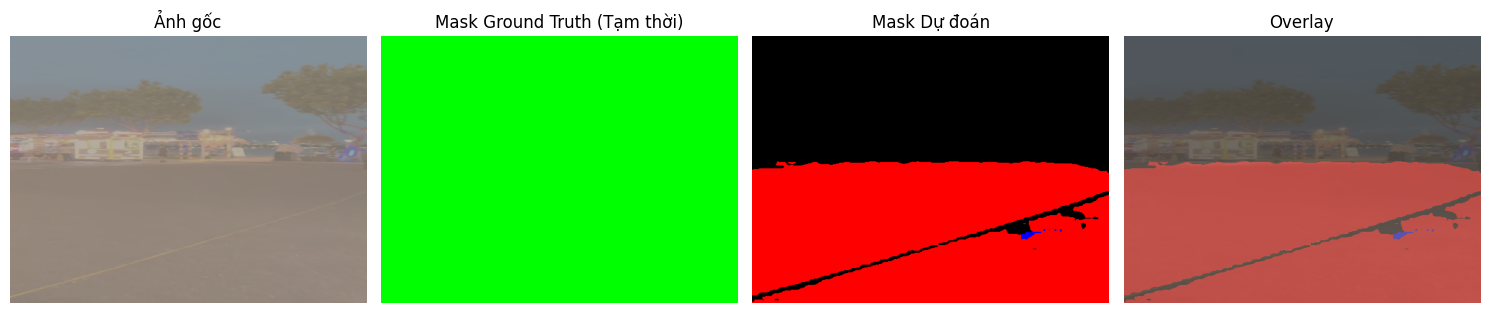

Hướng dẫn: Đang ở khu vực không an toàn! Không tìm thấy vỉa hè hoặc vạch kẻ đường.


In [71]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0016.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.40 ms


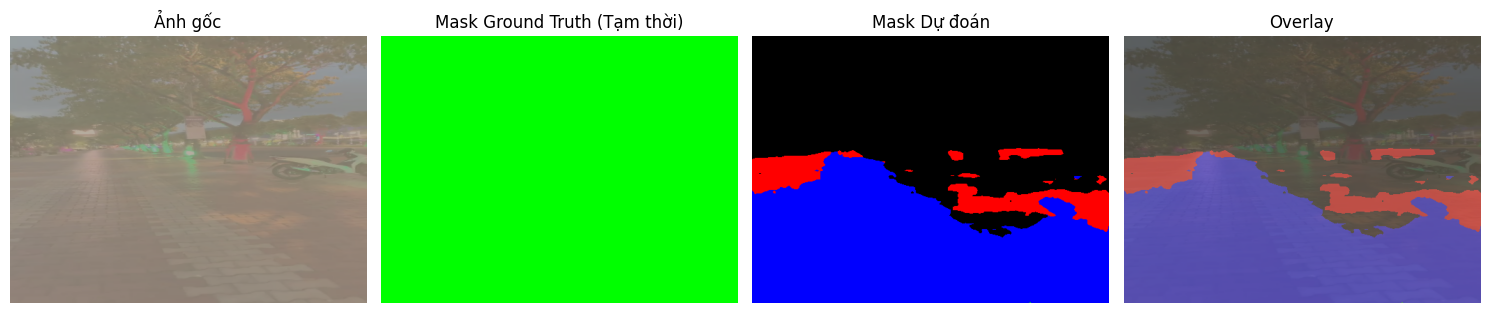

Hướng dẫn: Bạn đang đứng trên vỉa hè.


In [72]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0027.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.12 ms


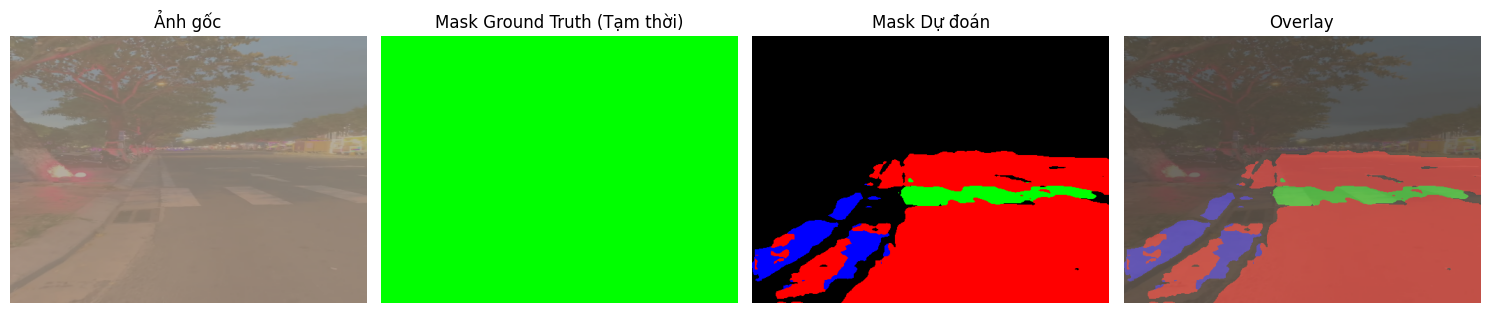

Hướng dẫn: Đang ở khu vực không an toàn! Hãy đi về bên trái để lên vỉa hè.


In [73]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0018.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 9.38 ms


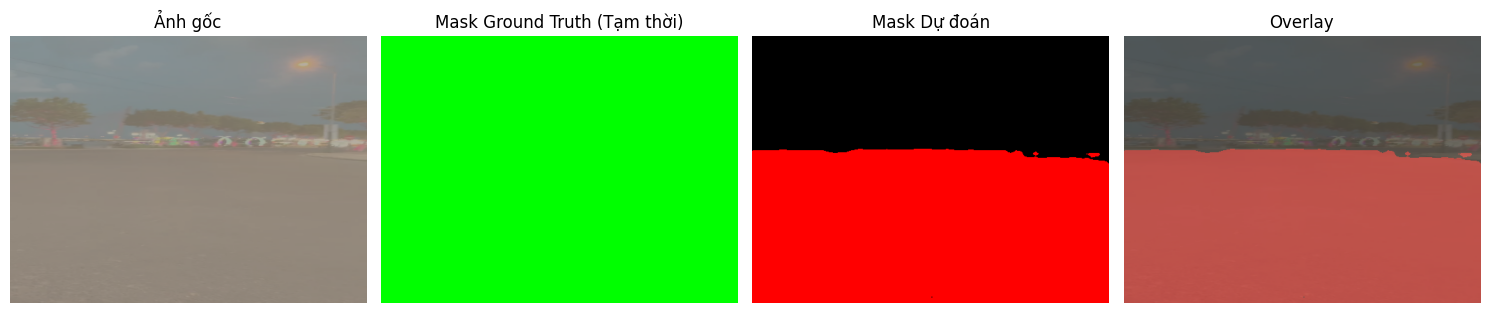

Hướng dẫn: Đang ở khu vực không an toàn! Không tìm thấy vỉa hè hoặc vạch kẻ đường.


In [76]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0012.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 8.63 ms


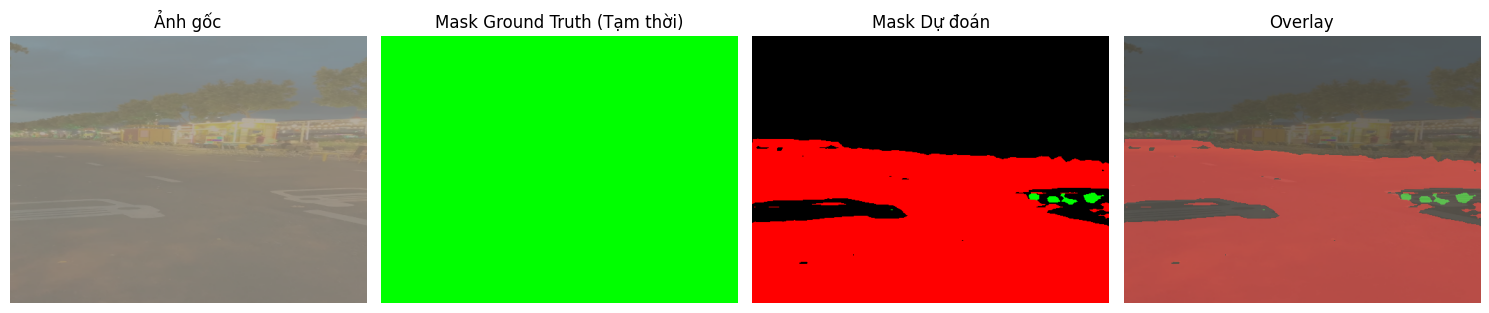

Hướng dẫn: Đang ở khu vực không an toàn! Không tìm thấy vỉa hè hoặc vạch kẻ đường.


In [78]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0021.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")

⏱ Thời gian suy luận: 10.91 ms


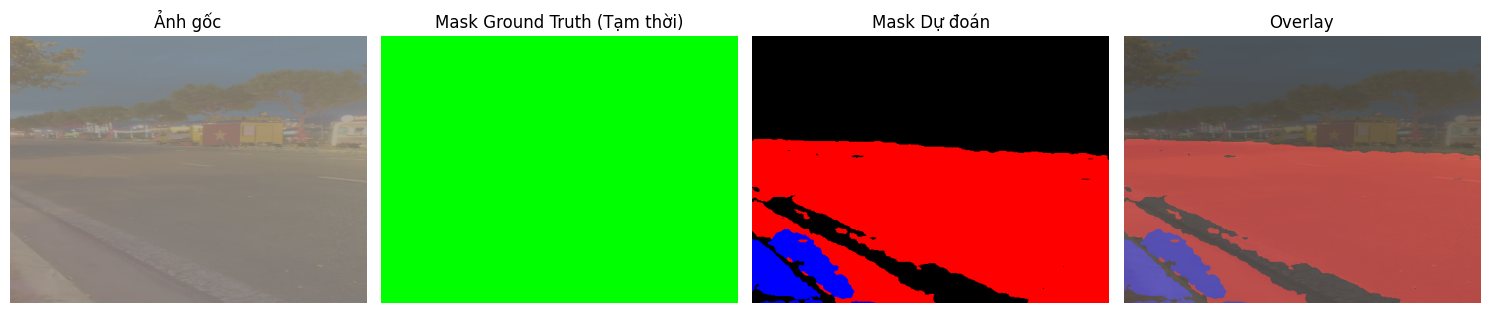

Hướng dẫn: Đang ở khu vực không an toàn! Hãy đi về bên trái để lên vỉa hè.


In [86]:
test_image_path = "/kaggle/input/test-data-deeplabv3/output_frames/frame_0029.jpg" 
img = cv2.imread(test_image_path)
if img is not None:
    guidance = predict_image(img)
    print(f"Hướng dẫn: {guidance}")
else:
    print("Error: Cannot load image")